# SageMaker Endpoint Testing Workshop

This notebook demonstrates how to test deployed SageMaker endpoints with different types of data.

## Prerequisites
- SageMaker endpoint deployed via CDK
- AWS credentials configured
- Required Python packages installed

## Setup and Imports

In [1]:
import boto3
import pandas as pd
import numpy as np
import csv
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set up AWS clients
sagemaker_client = boto3.client('sagemaker')
runtime_client = boto3.client('sagemaker-runtime')

print("✅ Setup complete!")

✅ Setup complete!


## 1. Discover Available Endpoints

In [3]:
def get_latest_endpoint():
    """Get the latest deployed endpoint name"""
    try:
        response = sagemaker_client.list_endpoints(
            SortBy='CreationTime',
            SortOrder='Descending',
            MaxResults=10
        )
        
        if not response['Endpoints']:
            return None
            
        for endpoint in response['Endpoints']:
            if endpoint['EndpointStatus'] == 'InService':
                return endpoint['EndpointName']
                
        return None
        
    except Exception as e:
        print(f"Error listing endpoints: {e}")
        return None

# Auto-detect the latest endpoint
endpoint_name = get_latest_endpoint()

if endpoint_name:
    print(f"🎯 Found endpoint: {endpoint_name}")
else:
    print("❌ No InService endpoints found. Please deploy an endpoint first.")
    endpoint_name = input("Enter endpoint name manually: ")

🎯 Found endpoint: dev-endpoint-20250918-141753


## 2. Basic Endpoint Testing

Let's start with a simple test using synthetic data.

In [4]:
def test_endpoint_simple(endpoint_name, test_data=None):
    """Test SageMaker endpoint with simple data"""
    
    # Default test data (10 features)
    if test_data is None:
        test_data = "1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0"
    
    try:
        print(f"Testing endpoint: {endpoint_name}")
        print(f"Test data: {test_data}")
        print("-" * 50)
        
        # Invoke endpoint
        response = runtime_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=test_data
        )
        
        # Parse response
        result = response['Body'].read().decode()
        
        print("✅ SUCCESS!")
        print(f"Prediction: {result}")
        print(f"Request ID: {response['ResponseMetadata']['RequestId']}")
        
        return float(result.strip())
        
    except Exception as e:
        print(f"❌ ERROR: {str(e)}")
        return None

# Test with simple data
if endpoint_name:
    prediction = test_endpoint_simple(endpoint_name)
    print(f"\n🎉 Basic test completed! Prediction: {prediction}")

Testing endpoint: dev-endpoint-20250918-141753
Test data: 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
--------------------------------------------------
✅ SUCCESS!
Prediction: 15.682673454284668
Request ID: 8dc9f2eb-49cc-4bf1-aab2-68a53eaeadd2

🎉 Basic test completed! Prediction: 15.682673454284668


## 3. Load and Test with Abalone Dataset

Now let's test with real data from the abalone dataset.

In [5]:
# Load abalone dataset
import os

# Use the abalone dataset file in the data folder
abalone_file = "data/abalone-dataset.csv"

if os.path.exists(abalone_file):
    print(f"📁 Using dataset from: {abalone_file}")
else:
    print(f"⚠️  Dataset not found at {abalone_file}")
    print("Please check the data folder.")

📁 Using abalone dataset from: /Users/nanagpal/Downloads/abalone-dataset.csv


In [6]:
def preprocess_abalone_data(csv_file, num_records=20):
    """Preprocess abalone data for model inference - pad to 10 features"""
    
    features_list = []
    actual_rings = []
    
    # Sex encoding mapping
    sex_mapping = {'M': '0', 'F': '1', 'I': '2'}
    
    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)
        
        for i, row in enumerate(csv_reader):
            if i >= num_records:
                break
                
            # Parse row: sex, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, rings
            sex = row[0]
            features = row[1:8]  # Skip rings (last column)
            rings = int(row[8])
            
            # Encode sex
            sex_encoded = sex_mapping.get(sex, '0')
            
            # Create feature list: encoded_sex + other features + padding
            feature_values = [sex_encoded] + features
            
            # Pad to 10 features if needed (model expects 10)
            while len(feature_values) < 10:
                feature_values.append('0.0')  # Pad with zeros
            
            # Create feature string
            feature_string = ','.join(feature_values)
            
            features_list.append(feature_string)
            actual_rings.append(rings)
    
    return features_list, actual_rings

# Load and preprocess data
if os.path.exists(abalone_file):
    print("📊 Loading abalone dataset...")
    features_list, actual_rings = preprocess_abalone_data(abalone_file, 10)
    print(f"✅ Loaded {len(features_list)} records")
    print(f"Sample feature vector: {features_list[0]}")
    print(f"Feature count: {len(features_list[0].split(','))}")
else:
    print("⚠️  Skipping abalone data loading - file not found")
    features_list, actual_rings = [], []

📊 Loading abalone dataset...
✅ Loaded 10 records
Sample feature vector: 0,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,0.0,0.0
Feature count: 10


## 4. Batch Testing with Abalone Data

In [7]:
def test_endpoint_batch(endpoint_name, features_list, actual_rings):
    """Test SageMaker endpoint with batch data"""
    
    if not features_list:
        print("❌ No data to test with")
        return []
    
    print(f"🧪 Testing endpoint: {endpoint_name}")
    print(f"📊 Number of test records: {len(features_list)}")
    print("-" * 70)
    
    results = []
    
    for idx, (features, actual_ring) in enumerate(zip(features_list, actual_rings)):
        try:
            # Invoke endpoint
            response = runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='text/csv',
                Body=features
            )
            
            # Parse response
            prediction = float(response['Body'].read().decode().strip())
            error = abs(prediction - actual_ring)
            
            results.append({
                'record': idx + 1,
                'prediction': prediction,
                'actual': actual_ring,
                'error': error
            })
            
            print(f"Record {idx + 1:2d}: Predicted={prediction:6.2f}, Actual={actual_ring:2.0f}, Error={error:5.2f}")
            
        except Exception as e:
            print(f"❌ ERROR on record {idx + 1}: {str(e)}")
            results.append({
                'record': idx + 1,
                'prediction': None,
                'actual': actual_ring,
                'error': None
            })
    
    return results

# Run batch testing
if endpoint_name and features_list:
    results = test_endpoint_batch(endpoint_name, features_list, actual_rings)
else:
    results = []
    print("⚠️  Skipping batch testing - no endpoint or data available")

🧪 Testing endpoint: dev-endpoint-20250918-141753
📊 Number of test records: 10
----------------------------------------------------------------------
Record  1: Predicted=  7.91, Actual=15, Error= 7.09
Record  2: Predicted=  9.50, Actual= 7, Error= 2.50
Record  3: Predicted=  8.24, Actual= 9, Error= 0.76
Record  4: Predicted=  7.91, Actual=10, Error= 2.09
Record  5: Predicted=  8.51, Actual= 7, Error= 1.51
Record  6: Predicted=  7.97, Actual= 8, Error= 0.03
Record  7: Predicted=  8.19, Actual=20, Error=11.81
Record  8: Predicted=  8.04, Actual=16, Error= 7.96
Record  9: Predicted=  7.91, Actual= 9, Error= 1.09
Record 10: Predicted=  8.89, Actual=19, Error=10.11


## 5. Results Analysis and Visualization

📊 SUMMARY STATISTICS:
Total records: 10
Successful predictions: 10
Failed predictions: 0
Average prediction: 8.31
Average actual: 12.00
Mean Absolute Error: 4.49
Min Error: 0.03
Max Error: 11.81
Standard Deviation of Errors: 4.10


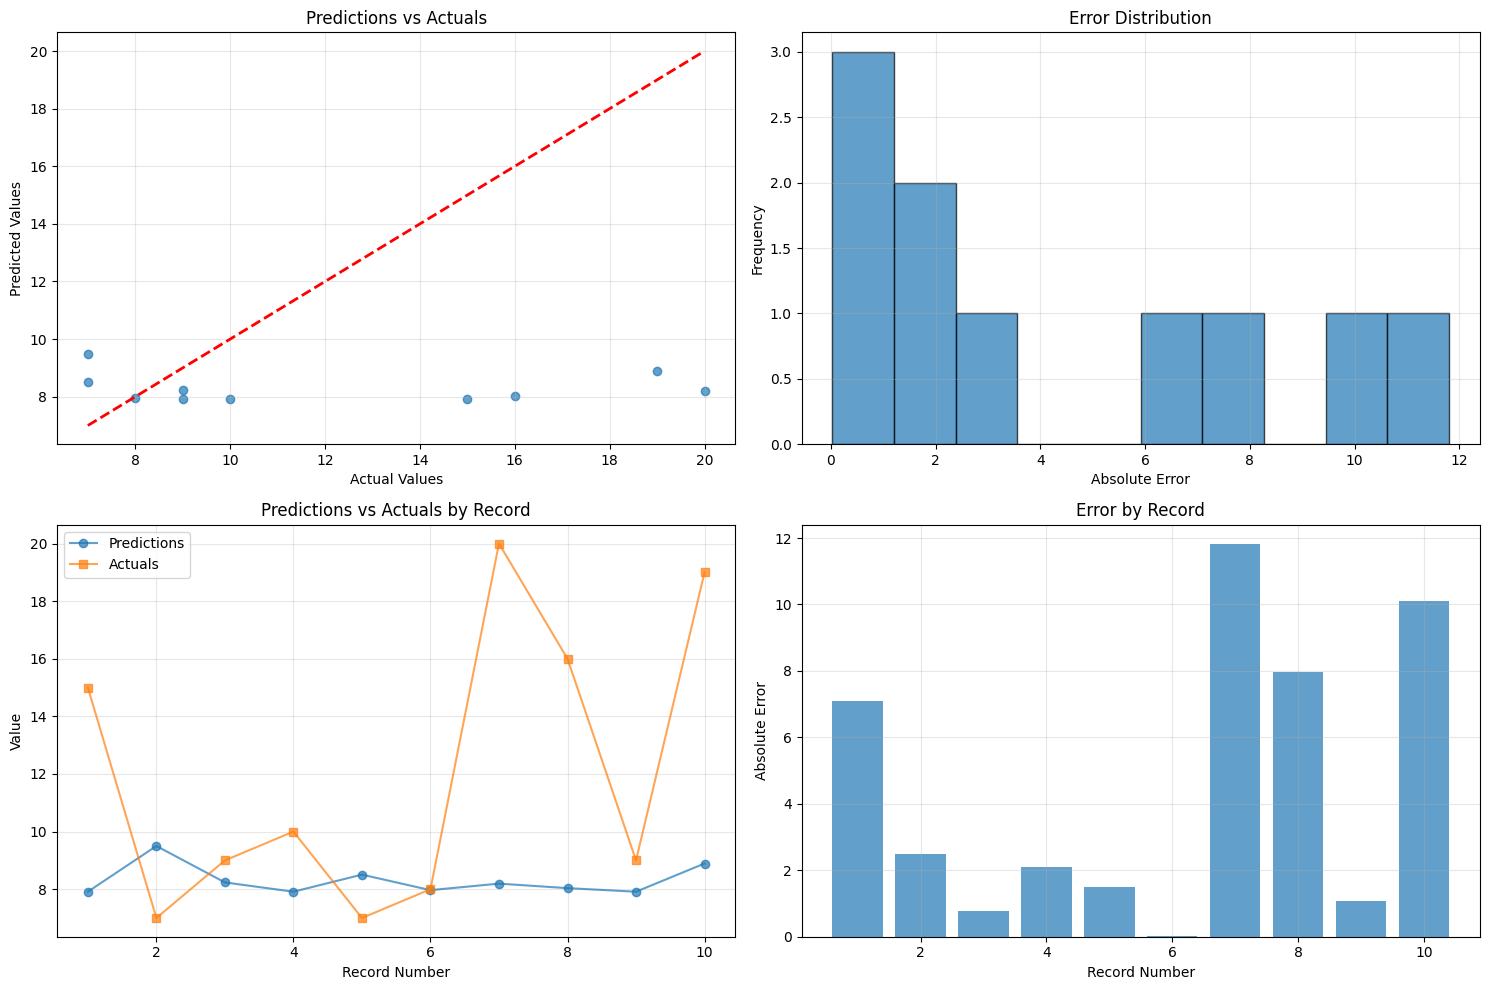

In [8]:
def analyze_results(results):
    """Analyze and visualize test results"""
    
    if not results:
        print("❌ No results to analyze")
        return
    
    successful_results = [r for r in results if r['prediction'] is not None]
    
    if not successful_results:
        print("❌ No successful predictions to analyze")
        return
    
    # Extract data for analysis
    predictions = [r['prediction'] for r in successful_results]
    actuals = [r['actual'] for r in successful_results]
    errors = [r['error'] for r in successful_results]
    
    # Print summary statistics
    print("📊 SUMMARY STATISTICS:")
    print(f"Total records: {len(results)}")
    print(f"Successful predictions: {len(successful_results)}")
    print(f"Failed predictions: {len(results) - len(successful_results)}")
    print(f"Average prediction: {np.mean(predictions):.2f}")
    print(f"Average actual: {np.mean(actuals):.2f}")
    print(f"Mean Absolute Error: {np.mean(errors):.2f}")
    print(f"Min Error: {np.min(errors):.2f}")
    print(f"Max Error: {np.max(errors):.2f}")
    print(f"Standard Deviation of Errors: {np.std(errors):.2f}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Predictions vs Actuals scatter plot
    axes[0, 0].scatter(actuals, predictions, alpha=0.7)
    axes[0, 0].plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Predictions vs Actuals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Error distribution histogram
    axes[0, 1].hist(errors, bins=10, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Absolute Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Error Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Predictions and actuals over records
    record_nums = [r['record'] for r in successful_results]
    axes[1, 0].plot(record_nums, predictions, 'o-', label='Predictions', alpha=0.7)
    axes[1, 0].plot(record_nums, actuals, 's-', label='Actuals', alpha=0.7)
    axes[1, 0].set_xlabel('Record Number')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].set_title('Predictions vs Actuals by Record')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Error by record
    axes[1, 1].bar(record_nums, errors, alpha=0.7)
    axes[1, 1].set_xlabel('Record Number')
    axes[1, 1].set_ylabel('Absolute Error')
    axes[1, 1].set_title('Error by Record')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_records': len(results),
        'successful_predictions': len(successful_results),
        'mean_absolute_error': np.mean(errors),
        'predictions': predictions,
        'actuals': actuals,
        'errors': errors
    }

# Analyze results
if results:
    analysis = analyze_results(results)
else:
    print("⚠️  No results to analyze")

## 6. Check Data Capture Configuration

Let's verify that data capture is enabled for monitoring.

In [9]:
def check_data_capture(endpoint_name):
    """Check if data capture is enabled for the endpoint"""
    
    try:
        response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        
        if 'DataCaptureConfig' in response:
            config = response['DataCaptureConfig']
            print("📊 DATA CAPTURE STATUS:")
            print(f"✅ Enabled: {config['EnableCapture']}")
            print(f"📈 Status: {config['CaptureStatus']}")
            print(f"🎯 Sampling: {config['CurrentSamplingPercentage']}%")
            print(f"📁 S3 Location: {config['DestinationS3Uri']}")
            
            return config
        else:
            print("❌ Data capture is not configured for this endpoint")
            return None
            
    except Exception as e:
        print(f"❌ Error checking data capture: {e}")
        return None

# Check data capture
if endpoint_name:
    data_capture_config = check_data_capture(endpoint_name)
else:
    print("⚠️  No endpoint available to check")

📊 DATA CAPTURE STATUS:
✅ Enabled: True
📈 Status: Started
🎯 Sampling: 100%
📁 S3 Location: s3://sagemaker-model-monitor-006230620263-us-west-2-dev/data-capture


## 7. Custom Testing Function

Create your own test data and run predictions.

In [10]:
# Create custom test data
# Format: 10 comma-separated values
custom_test_data = [
    "0,0.5,0.4,0.1,0.6,0.2,0.1,0.2,0.0,0.0",  # Small abalone-like
    "1,0.6,0.5,0.15,0.8,0.3,0.15,0.25,0.0,0.0",  # Medium abalone-like
    "2,0.7,0.6,0.2,1.0,0.4,0.2,0.3,0.0,0.0",   # Large abalone-like
]

print("🧪 Testing with custom data:")
custom_results = []

for i, test_data in enumerate(custom_test_data, 1):
    if endpoint_name:
        try:
            response = runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='text/csv',
                Body=test_data
            )
            
            prediction = float(response['Body'].read().decode().strip())
            custom_results.append(prediction)
            
            print(f"Test {i}: {test_data[:30]}... → Prediction: {prediction:.2f}")
            
        except Exception as e:
            print(f"❌ Error in test {i}: {e}")
            custom_results.append(None)
    else:
        print("⚠️  No endpoint available for testing")
        break

print(f"\n📊 Custom test results: {custom_results}")

🧪 Testing with custom data:
Test 1: 0,0.5,0.4,0.1,0.6,0.2,0.1,0.2,... → Prediction: 8.04
Test 2: 1,0.6,0.5,0.15,0.8,0.3,0.15,0.... → Prediction: 8.28
Test 3: 2,0.7,0.6,0.2,1.0,0.4,0.2,0.3,... → Prediction: 8.14

📊 Custom test results: [8.035154342651367, 8.278036117553711, 8.136625289916992]


## 8. Summary and Next Steps

This notebook demonstrated:
1. ✅ Endpoint discovery and basic testing
2. ✅ Real data preprocessing and batch testing
3. ✅ Results analysis and visualization
4. ✅ Data capture verification
5. ✅ Custom data testing

### Next Steps:
- Check CloudWatch dashboards for endpoint metrics
- Explore captured data in S3 for model monitoring
- Set up automated testing pipelines
- Configure alerts for endpoint performance

In [ ]:
# Final summary
print("🎉 WORKSHOP COMPLETE!")
print("\n📋 Summary:")
if endpoint_name:
    print(f"✅ Tested endpoint: {endpoint_name}")
if results:
    successful = len([r for r in results if r['prediction'] is not None])
    print(f"✅ Batch tests: {successful}/{len(results)} successful")
if custom_results:
    successful_custom = len([r for r in custom_results if r is not None])
    print(f"✅ Custom tests: {successful_custom}/{len(custom_results)} successful")
if data_capture_config:
    print(f"✅ Data capture: {data_capture_config['CaptureStatus']} ({data_capture_config['CurrentSamplingPercentage']}%)")

print("\n🔗 Useful Links:")
print("- AWS Console → SageMaker → Endpoints")
print("- AWS Console → CloudWatch → Dashboards")
print("- AWS Console → S3 → Data Capture Bucket")